###후판공정 Scale 불량 영향 인자 분석 및 개선안 도출

In [ ]:
!pip install koreanize-matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 17.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd # 데이터 구성 패키지( series, dataframe )
import numpy as np # 행렬 연산 패키지
import matplotlib # 시각화
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 데이터 프레임 출력 옵션
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns', None) # 컬럼 모두 표기

# pandas 지수 표현 제거 & 소수점 아래 4자리까지 표기
pd.options.display.float_format = '{:,.4f}'.format

pd.set_option('display.max_rows',400) # 데이터 프레임 출력 옵션
sns.set(style='whitegrid') # 기본 스타일 설정
plt.rcParams['axes.unicode_minus']=False # 음수 표시

# 에러 무시
import warnings
warnings.filterwarnings(action='ignore')

# Y축을 더 보기 좋게
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

import koreanize_matplotlib # 한글 표시

In [ ]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, scale
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans, DBSCAN
from sklearn.svm import SVC
from sklearn import metrics
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy import stats
from scipy.stats import chi2_contingency

# 변수 중요도 확인 : f1-score 기준
from xgboost import plot_importance
from lightgbm import plot_importance

In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###_1. 데이터 불러오기

In [ ]:
# 데이터 불러오기
df_org=pd.read_csv("/content/drive/MyDrive/Projects/Scale Project/SCALE불량.csv", encoding='cp949')

In [ ]:
df_raw=df_org.copy()
df_raw.head(3)

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
0,PLT_1001,03JAN2023:07:07:53,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,1호기,1열,1144,116,1133,59,259,1133,TMCP(온도제어),934,8,1조
1,PLT_1002,03JAN2023:07:21:22,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,1호기,2열,1144,122,1135,53,238,1135,TMCP(온도제어),937,8,1조
2,PLT_1003,03JAN2023:07:31:15,양품,NV-E36-TM,영국,T,33,3600,19200,적용,2호기,1열,1129,116,1121,55,258,1121,TMCP(온도제어),889,8,1조


In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   plate_no         1000 non-null   object
 1   rolling_date     1000 non-null   object
 2   scale            1000 non-null   object
 3   spec_long        1000 non-null   object
 4   spec_country     1000 non-null   object
 5   steel_kind       1000 non-null   object
 6   pt_thick         1000 non-null   int64 
 7   pt_width         1000 non-null   int64 
 8   pt_length        1000 non-null   int64 
 9   hsb              1000 non-null   object
 10  fur_no           1000 non-null   object
 11  fur_input_row    1000 non-null   object
 12  fur_heat_temp    1000 non-null   int64 
 13  fur_heat_time    1000 non-null   int64 
 14  fur_soak_temp    1000 non-null   int64 
 15  fur_soak_time    1000 non-null   int64 
 16  fur_total_time   1000 non-null   int64 
 17  fur_ex_temp      1000 non-null   i

#### 1.1. 데이터 구성 확인

| idx | column | desc | type |
| --- | --- | --- | --- |
| 0| plate_no | 제품 번호 | ID |
| 1 | rolling_date | 열연작업시각( 후판압연은 계절/시간적 영향 받지X ) | 날짜 |
| 2 | scale | 스케일( 산화철 ) 불량 여부 | 목표 변수 |
| 3 | spec_log | 제품 규격( 해당 규격은 특정 국가의 기준에 맞춰야 함 ) | 설명 변수 |
| 4 | spec_country | 제품 규격의 기준이 되는 국가를 나타내는 변수 | 설명 변수 |
| 5 | steel_kind | 강종( 탄소강(스케일이 잘 생김), 티타늄강(스케일 잘 생기지 않음) ) | 설명 변수 |
| 6 | pt_thick | 후판 지시 두께(mm) | 설명 변수 |
| 7 | pt_width | 후판 지시폭(mm) | 설명 변수 |
| 8 | pt_length | 후판 지시 길이(mm) | 설명 변수 |
| 9 | hsb | Hot scale Braker 적용 여부( 스케일이 발생하지 않도록 도와주는 장치 ) | 설명 변수 |
| 10 | fur_no | 가열로 호기( 가열로 호기마다 같은 제품이지만 미세한 성능의 차이가 보일 수 있음 ) | 설명 변수 |
| 11 | fur_input_row | 가열로 장입열( 가열로에 장입된 열을 나타내는 변수, 장입 순서에 가까운 개념 ) | 설명 변수 |
| 12 | fur_heat_temp | 가열로의 가열대 소재 온도 | 설명 변수 |
| 13 | fur_heat_time | 가열로 가열대 재로시간(분) | 설명 변수 |
| 14 | fur_soak_temp | 가열로 균열대 소재온도 | 설명 변수 |
| 15 | fur_total_time | 가열로 총 재로시간(분) -> 예열대+가열대+균열대 | 설명 변수 |
| 16 | fur_ex_temp | 가열로 추출온도( 계산치 ) | 설명 변수 |
| 17 | rolling_method | 압연방법( TMCP(Temperature-Mechanical Controlled Processing) / CR(Cold Rolling) ) -> 스케일 제거 | 설명 변수 |
| 18 | rolling_temp | 압연 온도( 압연 과정 동안 유지되는 주변 온도 ) | 설명 변수 |
| 19 | descaling_count | 압연 디스케일링 횟수( 에어건이나 물을 사용하여 스케일을 제거하는 작업 ) | 설명 변수 |
| 20 | work_group | 작업조 4조 2교대( 07시/19시 기준 ) | 설명 변수 |

In [ ]:
# 결측값 확인
df_raw.isnull().sum()

,0
plate_no,0
rolling_date,0
scale,0
spec_long,0
spec_country,0
steel_kind,0
pt_thick,0
pt_width,0
pt_length,0
hsb,0




```
결측값은 보이지 않았다.
```

In [ ]:
# 목표변수 기술통계량 확인
df_raw['scale'].describe()

,scale
count,1000
unique,2
top,양품
freq,690


In [ ]:
# 범주형 변수 요약통계 확인
df_raw.describe(include='object')

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,hsb,fur_no,fur_input_row,rolling_method,work_group
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,1000,1000,2,66,7,2,2,3,2,2,4
top,PLT_1001,03JAN2023:07:07:53,양품,JS-SM490YB,영국,C,적용,3호기,1열,CR(제어압연),2조
freq,1,1,690,84,256,755,953,342,508,840,292


In [ ]:
# 수치형 변수 요약통계 확인
df_raw.describe()

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_temp,descaling_count
count,"1,000.0000","1,000.0000","1,000.0000","1,000.0000","1,000.0000","1,000.0000","1,000.0000","1,000.0000","1,000.0000","1,000.0000","1,000.0000"
mean,26.7820,"2,831.9000","36,788.2000","1,157.2450",85.9720,"1,150.9280",71.7200,238.5890,"1,150.9280",934.6370,8.5570
std,18.1376,494.0815,"13,912.3871",21.2450,26.3463,17.3444,20.6021,38.1948,17.3444,96.5980,1.6042
min,12.0000,"1,800.0000","7,900.0000","1,103.0000",55.0000,"1,113.0000",35.0000,165.0000,"1,113.0000",0.0000,5.0000
25%,15.0000,"2,500.0000","26,650.0000","1,140.0000",66.0000,"1,135.7500",57.7500,210.0000,"1,135.7500",893.7500,8.0000
50%,19.0000,"2,800.0000","40,400.0000","1,159.0000",75.0000,"1,156.0000",66.0000,230.0000,"1,156.0000",948.0000,9.0000
75%,34.0000,"3,100.0000","49,100.0000","1,173.0000",102.2500,"1,164.0000",81.0000,263.0000,"1,164.0000",991.0000,10.0000
max,100.0000,"4,600.0000","54,900.0000","1,206.0000",158.0000,"1,185.0000",145.0000,362.0000,"1,185.0000","1,078.0000",10.0000


####1.2. 이상치 확인

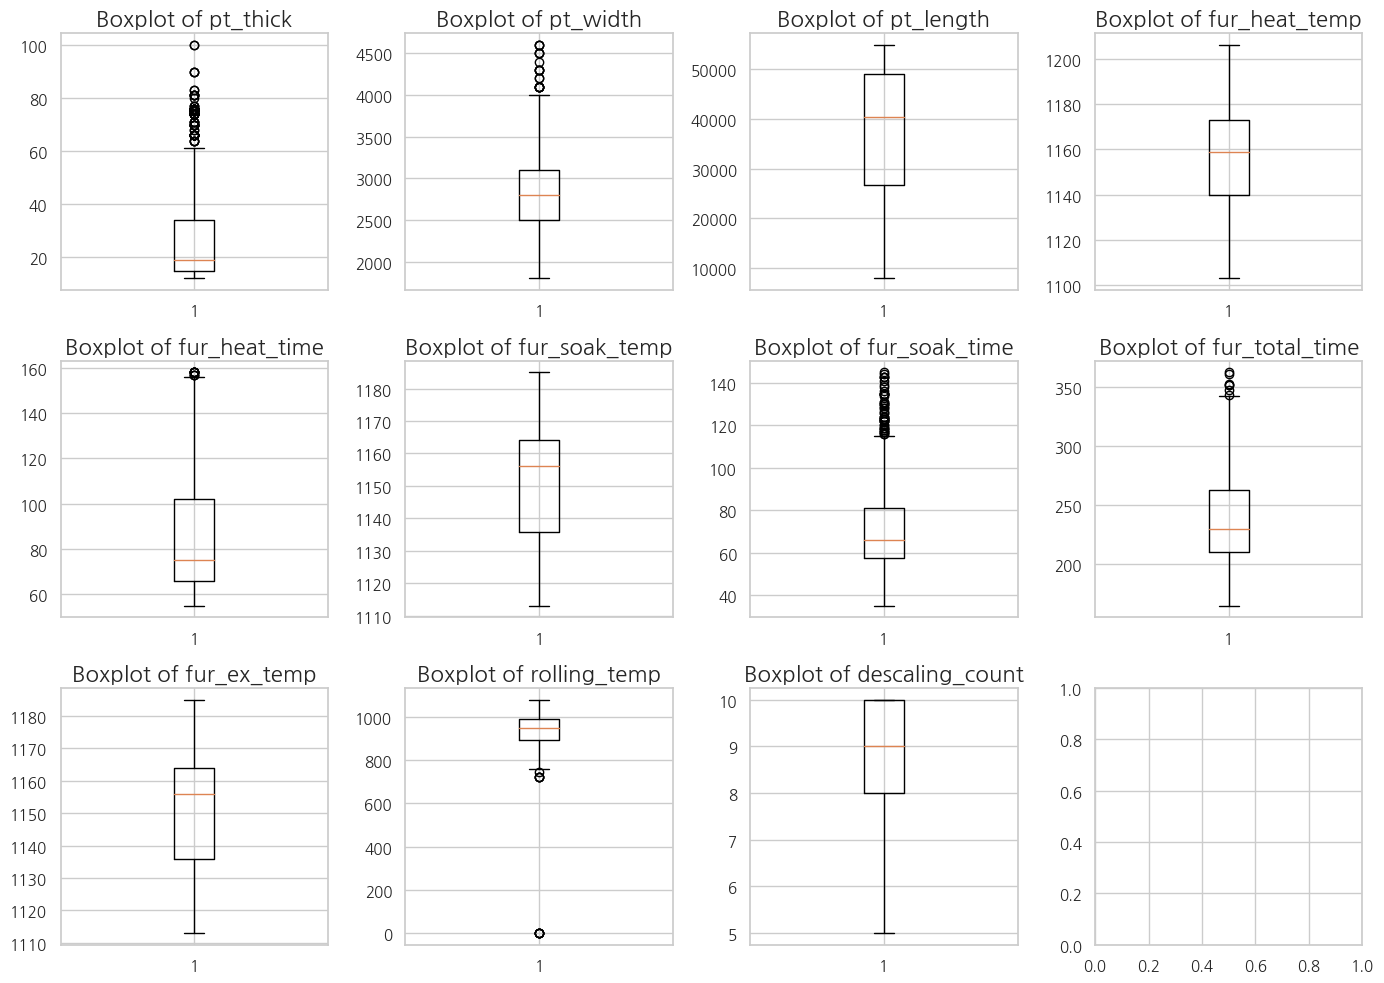

In [ ]:
# Boxplot으로 이상치 확인
var = ['pt_thick','pt_width','pt_length','fur_heat_temp','fur_heat_time', 'fur_soak_temp',
       'fur_soak_time','fur_total_time', 'fur_ex_temp','rolling_temp','descaling_count']

fig, axes = plt.subplots(3, 4, figsize=(14, 10))
axes = axes.flatten() # 2차원 배열을 1차원으로 펼치기

for i, var in enumerate(var):
  axes[i].boxplot(df_raw[var])
  axes[i].set_title(f"Boxplot of {var}", fontsize=16)

plt.tight_layout() # subplot 간 간격 조정
plt.show()

```
위 boxplot을 통해 rolling_temp( 압연 온도 )에서 이상치를 발견하였다.   
(참고: rolling_temp는 압연 과정 동안 유지되는 주변 온도이다.)
   
온도가 아무리 낮아도 공정 과정 중 압연 온도는 0도 이상일 것이라고 생각한다.
```

In [ ]:
# rolling_temp의 기술통계량 확인
df_raw['rolling_temp'].describe()

,rolling_temp
count,"1,000.0000"
mean,934.6370
std,96.5980
min,0.0000
25%,893.7500
50%,948.0000
75%,991.0000
max,"1,078.0000"


In [ ]:
df_raw[df_raw['rolling_temp'] == 0]

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
53,PLT_1054,03JAN2023:16:22:29,양품,GL-E36-TM,독일,T,56,3800,11400,적용,3호기,2열,1132,95,1128,80,244,1128,TMCP(온도제어),0,6,1조
221,PLT_1222,04JAN2023:19:44:09,양품,JS-SM490YB,일본,C,16,2200,43600,적용,3호기,2열,1163,57,1166,67,228,1166,CR(제어압연),0,10,2조
222,PLT_1223,04JAN2023:19:56:39,양품,JS-SM490YB,일본,C,16,2200,43600,적용,3호기,1열,1169,64,1164,61,188,1164,CR(제어압연),0,10,2조
598,PLT_1599,07JAN2023:11:40:51,양품,PILAC-BT33,한국,T,81,2100,12900,적용,2호기,1열,1133,89,1122,59,229,1122,CR(제어압연),0,6,3조
599,PLT_1600,07JAN2023:11:52:00,양품,PILAC-BT33,한국,T,81,2100,13200,적용,1호기,2열,1130,92,1124,61,210,1124,CR(제어압연),0,6,3조
600,PLT_1601,07JAN2023:11:59:10,양품,NV-D32-TM,영국,T,40,2500,23600,적용,3호기,1열,1119,109,1117,76,260,1117,TMCP(온도제어),0,6,3조


```
rolling_temp가 0도인 데이터는 6개이다.
위 데이터들은 모두 양품이며, 제품 규격을 알 수 있으므로 제거하지 않고,
동일한 제품 규격(spec_long)을 가지는 데이터들의 평균치로 대체하기로 결정하였다.
```

In [ ]:
# spec_log(제품 규격) : GL-E36-TM
df_raw[df_raw['spec_long'] == 'GL-E36-TM'].head(2)

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
26,PLT_1027,03JAN2023:11:37:34,양품,GL-E36-TM,독일,T,44,2000,27500,적용,2호기,1열,1114,64,1120,82,240,1120,TMCP(온도제어),836,6,1조
27,PLT_1028,03JAN2023:11:44:48,양품,GL-E36-TM,독일,T,44,2000,27500,적용,3호기,1열,1113,124,1120,82,276,1120,TMCP(온도제어),832,6,1조


In [ ]:
df_raw[df_raw['spec_long'] == 'GL-E36-TM']['rolling_temp'].mean()

789.8125

In [ ]:
# spec_log(제품 규격) : JS-SM490YB
df_raw[df_raw['spec_long'] == 'JS-SM490YB'].head(2)

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
121,PLT_1122,04JAN2023:03:42:56,양품,JS-SM490YB,일본,C,14,3300,51200,적용,1호기,1열,1140,80,1131,117,286,1131,CR(제어압연),915,10,2조
122,PLT_1123,04JAN2023:03:50:27,양품,JS-SM490YB,일본,C,14,3300,51200,적용,1호기,2열,1142,74,1132,123,284,1132,CR(제어압연),923,10,2조


In [ ]:
df_raw[df_raw['spec_long'] == 'JS-SM490YB']['rolling_temp'].mean()

955.6190476190476

In [ ]:
# spec_log(제품 규격) : PILAC-BT33
df_raw[df_raw['spec_long'] == 'PILAC-BT33'].head(2)

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
551,PLT_1552,07JAN2023:03:22:46,양품,PILAC-BT33,한국,T,40,2500,16900,적용,2호기,1열,1165,112,1122,135,333,1122,CR(제어압연),910,6,2조
552,PLT_1553,07JAN2023:03:34:39,양품,PILAC-BT33,한국,T,40,1800,18900,적용,2호기,2열,1170,105,1117,135,338,1117,CR(제어압연),906,6,2조


In [ ]:
df_raw[df_raw['spec_long'] == 'PILAC-BT33']['rolling_temp'].mean()

841.325

In [ ]:
# spect_log(제품 규격) : NV-D32-TM
df_raw[df_raw['spec_long'] == 'NV-D32-TM'].head(2)

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
533,PLT_1534,07JAN2023:00:22:33,양품,NV-D32-TM,영국,T,40,2100,26500,적용,3호기,1열,1173,92,1138,80,274,1138,TMCP(온도제어),895,6,2조
562,PLT_1563,07JAN2023:05:20:25,양품,NV-D32-TM,영국,T,40,2000,28900,적용,3호기,1열,1135,106,1121,126,322,1121,TMCP(온도제어),887,6,2조


In [ ]:
df_raw[df_raw['spec_long'] == 'NV-D32-TM']['rolling_temp'].mean()

668.25

In [ ]:
# 이상치를 동일 제품 규격 평균값으로 대체
df_raw.loc[df_raw['plate_no']=='PLT_1054', 'rolling_temp']=789.8125 # GL-E36-TM
df_raw.loc[df_raw['plate_no'].isin(['PLT_1222','PLT_1223']), 'rolling_temp']=955.6190476190476 # JS-SM490YB
df_raw.loc[df_raw['plate_no'].isin(['PLT_1599','PLT_1600']), 'rolling_temp']=841.325 # PILAC-BT33
df_raw.loc[df_raw['plate_no']=='PLT_1601', 'rolling_temp']=668.25 # NV-D32-TM

In [ ]:
# 이상치가 잘 대체되었는지 확인
df_raw[df_raw['rolling_temp']==0]

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group


In [ ]:
df_raw['rolling_temp'].describe() # rolling_temp 컬럼 기술 통계량 확인

,rolling_temp
count,"1,000.0000"
mean,939.6890
std,64.5712
min,668.2500
25%,894.0000
50%,948.0000
75%,991.0000
max,"1,078.0000"


####1.3. 분석하기 좋은 데이터로 만들기

#####1.3.1. 불필요한 설명변수 제거

In [ ]:
df_raw.groupby(['spec_country','spec_long','scale'])['plate_no'].count()

spec_country  spec_long    scale
공통            COMMON       불량        3
                           양품       33
독일            GL-A         불량        6
                           양품       11
              GL-A32       불량        2
                           양품       22
              GL-A32-TM    불량        1
                           양품        3
              GL-A36-TM    양품       11
              GL-D36-TM    불량        2
                           양품        7
              GL-E32-TM    불량        1
                           양품        5
              GL-E36-TM    불량        1
                           양품       15
미국            A131-DH36TM  불량        1
              A283-C       불량        5
                           양품        1
              A516-60      불량        2
                           양품        1
              A709-36      양품        1
              AB/A         불량       13
                           양품       38
              AB/AH32      불량        8
                           양품       23
              AB/B         불량        3
                           양품        6
              AB/EH32-TM   양품        2
              AB/EH36-TM   불량        2
                           양품       30
              API-2W-50T   양품        2
              SA283-C      불량       10
                           양품       11
영국            LR-A         불량       25
                           양품       56
              LR-AH32      불량       16
                           양품       36
              LR-AH36      양품        1
              LR-AH36-TM   양품        1
              LR-B         불량        6
                           양품        7
              LR-EH32-TM   불량        1
              LR-EH36-TM   양품        2
              NV-A         불량       14
                           양품       34
              NV-A32       불량        9
                           양품       24
              NV-A32-TM    불량        1
                           양품        2
              NV-A36-TM    양품        2
              NV-B         불량        2
                           양품        1
              NV-D32-TM    양품        4
              NV-D36-TM    불량        1
                           양품        4
              NV-E32-TM    양품        2
              NV-E36-TM    양품        5
일본            JS-SM400A    불량        2
              JS-SM400B    불량        3
                           양품        3
              JS-SM490A    불량       27
                           양품        6
              JS-SM490YA   불량        4
                           양품        1
              JS-SM490YB   불량       35
                           양품       49
              JS-SS400     불량       22
                           양품        2
              NK-KA        불량        2
                           양품        8
              NK-KA32      불량        2
                           양품       17
              NK-KA32-TM   양품        1
              NK-KD36-TM   양품        3
프랑스           BV-A         불량        4
                           양품       15
              BV-AH32      불량        9
                           양품       25
              BV-AH32-TM   양품        4
              BV-AH36-TL   불량        1
                           양품        2
              BV-AH36-TM   불량        1
              BV-B         불량       10
                           양품       24
              BV-EH32-TM   양품        7
              BV-EH36-TM   불량        2
                           양품       37
              CCS-B        불량        2
한국            KR-A         불량       24
                           양품       22
              KR-AH32      불량        4
                           양품        7
              KR-B         불량        1
              KS-HSB500    양품        2
              KS-HSB600    양품        1
              KS-SM400A    불량        3
                           양품        1
              KS-SM400B    불량        3
                           양품        3
              KS-SM490A    불량        5
              KS-SM490B    불량        3
                           양



```
한 제품 규격( spec_long )은 한 국가에만 해당하며 66가지 제품 규격이 있다.
제품 규격이 scale에 직접적인 영향을 주지 않는다고 판단하여 spec_long 변수를 제거하기로 결정했다.
또한 spec_country은 제품 규격 기준국을 나타내는 변수이므로 함께 제거하기로 결정했다.
```



In [ ]:
%%time
df_raw.drop(['spec_long','spec_country'], axis=1, inplace=True)

CPU times: user 1.62 ms, sys: 61 µs, total: 1.68 ms
Wall time: 5.19 ms



```
plate_no( 제품 번호 )는 scale에 직접적인 영향을 미치지 않을 것으로 판단해서 제거하기로 결정했다.
```



In [ ]:
# scale과 직접적으로 관련 없는 변수 제거
%%time
df_raw.drop('plate_no', axis=1, inplace=True)

CPU times: user 2.58 ms, sys: 0 ns, total: 2.58 ms
Wall time: 2.56 ms


In [ ]:
df_raw.head(2)

,rolling_date,scale,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
0,03JAN2023:07:07:53,양품,T,32,3700,15100,적용,1호기,1열,1144,116,1133,59,259,1133,TMCP(온도제어),934.0000,8,1조
1,03JAN2023:07:21:22,양품,T,32,3700,15100,적용,1호기,2열,1144,122,1135,53,238,1135,TMCP(온도제어),937.0000,8,1조


#####1.3.2. Dtype 변경

In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rolling_date     1000 non-null   object 
 1   scale            1000 non-null   object 
 2   steel_kind       1000 non-null   object 
 3   pt_thick         1000 non-null   int64  
 4   pt_width         1000 non-null   int64  
 5   pt_length        1000 non-null   int64  
 6   hsb              1000 non-null   object 
 7   fur_no           1000 non-null   object 
 8   fur_input_row    1000 non-null   object 
 9   fur_heat_temp    1000 non-null   int64  
 10  fur_heat_time    1000 non-null   int64  
 11  fur_soak_temp    1000 non-null   int64  
 12  fur_soak_time    1000 non-null   int64  
 13  fur_total_time   1000 non-null   int64  
 14  fur_ex_temp      1000 non-null   int64  
 15  rolling_method   1000 non-null   object 
 16  rolling_temp     1000 non-null   float64
 17  descaling_count

In [ ]:
# scale: 양품=0, 불량품=1
%%time
df_raw['scale']=df_raw['scale'].map({'양품':0,  '불량':1})

CPU times: user 1.62 ms, sys: 0 ns, total: 1.62 ms
Wall time: 1.62 ms


In [ ]:
df_raw['scale'].value_counts()

,count
scale,
0,690
1,310


In [ ]:
df_raw['steel_kind'].unique()

array(['T', 'C'], dtype=object)

In [ ]:
# steel_kind: T=1, C=2
%%time
df_raw['steel_kind']=df_raw['steel_kind'].map({'T':1,  'C':2})

CPU times: user 2.56 ms, sys: 0 ns, total: 2.56 ms
Wall time: 2.76 ms


In [ ]:
df_raw['hsb'].unique()

array(['적용', '미적용'], dtype=object)

In [ ]:
# hsb: 적용=1, 미적용=2
%%time
df_raw['hsb']=df_raw['hsb'].map({'적용':1,  '미적용':2})

CPU times: user 2.92 ms, sys: 0 ns, total: 2.92 ms
Wall time: 6.07 ms


In [ ]:
df_raw['fur_no'].unique()

array(['1호기', '2호기', '3호기'], dtype=object)

In [ ]:
# fur_no: 1호기=1, 2호기=2, 3호기=3
%%time
df_raw['fur_no']=df_raw['fur_no'].map({'1호기':1,  '2호기':2, '3호기':3})

CPU times: user 2.47 ms, sys: 0 ns, total: 2.47 ms
Wall time: 2.91 ms


In [ ]:
df_raw['fur_input_row'].unique()

array(['1열', '2열'], dtype=object)

In [ ]:
# fur_input_row: 1열=1, 2열=2
%%time
df_raw['fur_input_row']=df_raw['fur_input_row'].map({'1열':1,  '2열':2})

CPU times: user 1.66 ms, sys: 0 ns, total: 1.66 ms
Wall time: 1.67 ms


In [ ]:
df_raw['rolling_method'].unique()

array(['TMCP(온도제어)', 'CR(제어압연)'], dtype=object)

In [ ]:
# rolling_method: TMCP(온도제어)=1, CR(제어압연)=2
%%time
df_raw['rolling_method']=df_raw['rolling_method'].map({'TMCP(온도제어)':1,  'CR(제어압연)':2})

CPU times: user 1.3 ms, sys: 29 µs, total: 1.33 ms
Wall time: 1.34 ms


In [ ]:
df_raw['work_group'].unique()

array(['1조', '2조', '3조', '4조'], dtype=object)

In [ ]:
# work_group: 1조=1, 2조=2, 3조=3, 4조=4
%%time
df_raw['work_group']=df_raw['work_group'].map({'1조':1,  '2조':2, '3조':3, '4조':4})

CPU times: user 1.84 ms, sys: 0 ns, total: 1.84 ms
Wall time: 3.29 ms


In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rolling_date     1000 non-null   object 
 1   scale            1000 non-null   int64  
 2   steel_kind       1000 non-null   int64  
 3   pt_thick         1000 non-null   int64  
 4   pt_width         1000 non-null   int64  
 5   pt_length        1000 non-null   int64  
 6   hsb              1000 non-null   int64  
 7   fur_no           1000 non-null   int64  
 8   fur_input_row    1000 non-null   int64  
 9   fur_heat_temp    1000 non-null   int64  
 10  fur_heat_time    1000 non-null   int64  
 11  fur_soak_temp    1000 non-null   int64  
 12  fur_soak_time    1000 non-null   int64  
 13  fur_total_time   1000 non-null   int64  
 14  fur_ex_temp      1000 non-null   int64  
 15  rolling_method   1000 non-null   int64  
 16  rolling_temp     1000 non-null   float64
 17  descaling_count

###_2. EDA

####2.1. 변수들 간의 상관관계 확인

In [ ]:
df_num = df_raw.select_dtypes(exclude='object')
df_num.head(2)

,scale,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
0,0,1,32,3700,15100,1,1,1,1144,116,1133,59,259,1133,1,934.0000,8,1
1,0,1,32,3700,15100,1,1,2,1144,122,1135,53,238,1135,1,937.0000,8,1


In [ ]:
temp_df=df_num[['scale','pt_thick','pt_width','pt_length','fur_heat_temp','fur_heat_time','fur_soak_temp','fur_soak_time','fur_total_time','fur_ex_temp','rolling_temp','descaling_count']]
sns.pairplot(temp_df, hue='scale')
plt.show()

Output hidden; open in https://colab.research.google.com to view.



```
산점도 확인 결과, 가열로 균열대 소재온도(fur_soak_temp)와 가열로 추출온도(fur_ex_temp)가 완벽히 비례하므로
하나의 변수만 사용해도 될 것 같다.
```





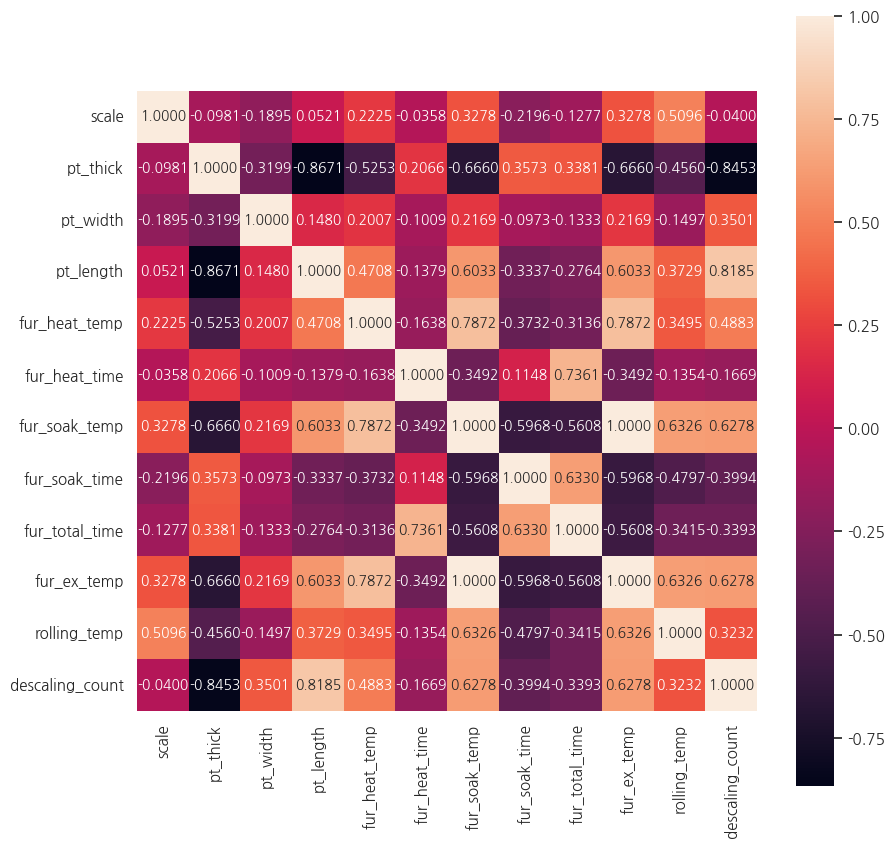

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(temp_df.corr(), annot=True, fmt=".4f", annot_kws={'size':10}, square=True)
plt.show()

```
1. fur_soak_temp(가열로 균열대 소재온도)와 fur_ex_temp(가열로 추출온도)의 상관계수는 1이므로 완전한 양의 상관관계를 띈다.
두 변수 간의 상관관계가 높으면 모델링 시 다중공선성이 발생할 수 있으므로 fur_ex_temp를 제거하기로 결정했다.

2. 상관관계 확인( 기준: 절댓값 0.7 이상 )
-steel_kind: pt_thick -0.81 / pt_length 0.79 / fur_soak_temp 0.78 /
             rolling_method 0.77 / descaling_count 0.75
-pt_thick: pt_length -0.87 / descaling_count -0.85
-pt_length: descaling_count -0.82
-fur_heat_temp: fur_soak_temp 0.79
-fur_heat_time: fur_total_time 0.74
-> 변수 간의 상관관계가 있는 것으로 보인다.
```



In [ ]:
# fur_ex_temp 제거
%%time
df_raw.drop('fur_ex_temp', axis=1, inplace=True)

CPU times: user 1.38 ms, sys: 15 µs, total: 1.39 ms
Wall time: 1.4 ms


####2.2. 범주형 변수와 scale 상관관계 확인

In [ ]:
df_raw.columns

Index(['rolling_date', 'scale', 'steel_kind', 'pt_thick', 'pt_width',
       'pt_length', 'hsb', 'fur_no', 'fur_input_row', 'fur_heat_temp',
       'fur_heat_time', 'fur_soak_temp', 'fur_soak_time', 'fur_total_time',
       'rolling_method', 'rolling_temp', 'descaling_count', 'work_group'],
      dtype='object')

In [ ]:
df_obj_x=df_raw[['rolling_date','steel_kind','hsb','fur_no','fur_input_row','work_group','descaling_count']]
df_obj_y=df_raw['scale']
df_obj_x.head(2)

,rolling_date,steel_kind,hsb,fur_no,fur_input_row,work_group,descaling_count
0,03JAN2023:07:07:53,1,1,1,1,1,8
1,03JAN2023:07:21:22,1,1,1,2,1,8


In [ ]:
# 목표변수(scale)과 범주형 설명변수 간의 관계 파악 - 카이제곱 검정
col_li=df_obj_x.columns
for col in col_li:
    cross_tbl = pd.crosstab(df_obj_x[col], df_obj_y)
    # chi2: 카이제곱 검정통계량, pval: p-value, dof: 자유도, expected: 기대치
    chi2, pval, dof, expected = chi2_contingency(cross_tbl)
    print(f"{col}")
    print(f"chi-square statistic: {chi2:.3f}")
    print(f"dof:                  {dof:.3f}")
    print(f"p-value:              {pval:.3f}")
    print(f"\n")

rolling_date
chi-square statistic: 1000.000
dof:                  999.000
p-value:              0.485


steel_kind
chi-square statistic: 77.710
dof:                  1.000
p-value:              0.000


hsb
chi-square statistic: 106.413
dof:                  1.000
p-value:              0.000


fur_no
chi-square statistic: 2.819
dof:                  2.000
p-value:              0.244


fur_input_row
chi-square statistic: 0.922
dof:                  1.000
p-value:              0.337


work_group
chi-square statistic: 13.846
dof:                  3.000
p-value:              0.003


descaling_count
chi-square statistic: 216.085
dof:                  5.000
p-value:              0.000




```
카이제곱 검정(유의수준 0.05)한 결과,
steel_kind, hsb, descaling_count는 scale에 많은 영향을 미친다.
rolling_date, fur_no, fur_input_row는 p-value가 0.05보다 높다.
세 변수는 scale과 독립적이므로 제거하기로 결정했다.

( 자유도 1: 3.84 / 자유도 2: 5.99 /
   자유도 3: 7.81 / 자유도 5: 11.07 )

```



In [ ]:
df_raw.drop(['rolling_date','fur_no', 'fur_input_row'], axis=1, inplace=True)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   scale            1000 non-null   int64  
 1   steel_kind       1000 non-null   int64  
 2   pt_thick         1000 non-null   int64  
 3   pt_width         1000 non-null   int64  
 4   pt_length        1000 non-null   int64  
 5   hsb              1000 non-null   int64  
 6   fur_heat_temp    1000 non-null   int64  
 7   fur_heat_time    1000 non-null   int64  
 8   fur_soak_temp    1000 non-null   int64  
 9   fur_soak_time    1000 non-null   int64  
 10  fur_total_time   1000 non-null   int64  
 11  rolling_method   1000 non-null   int64  
 12  rolling_temp     1000 non-null   float64
 13  descaling_count  1000 non-null   int64  
 14  work_group       1000 non-null   int64  
dtypes: float64(1), int64(14)
memory usage: 117.3 KB


####2.3. 연속형 변수와 scale 상관관계 확인

In [ ]:
df_num_x=df_raw.drop(['scale','steel_kind','hsb','rolling_method','work_group','descaling_count'], axis=1)
df_num_y=df_raw['scale']
df_num_x.head(1)

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp
0,32,3700,15100,1144,116,1133,59,259,934.0000


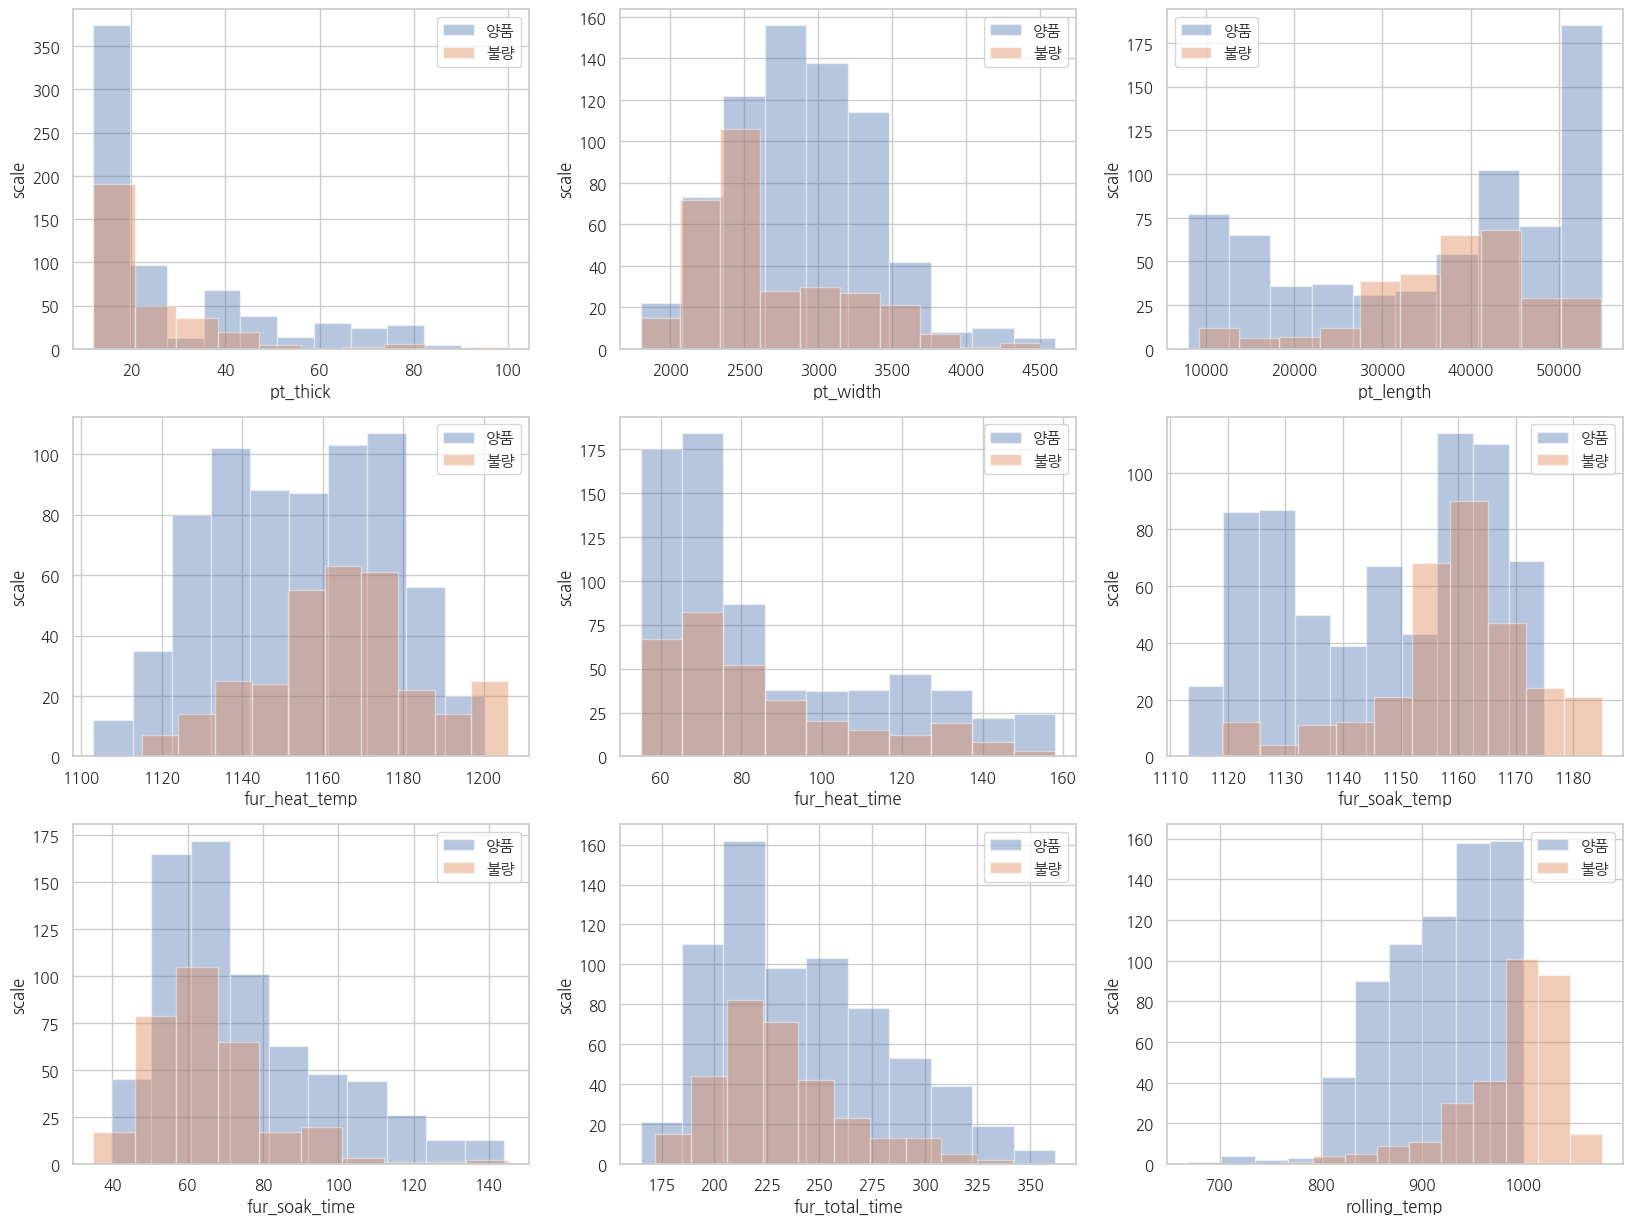

In [ ]:
fig,axes=plt.subplots(3,3,figsize=(20,15))
i=0
col=df_num_x.columns
for col in col:
    sns.distplot(
        df_num[df_num['scale']==0][col],
        label='양품',
        ax=axes[i//3, i%3],
        bins=10,
        kde=False)
    sns.distplot(
        df_num[df_num['scale']==1][col],
        label='불량',
        ax=axes[i//3, i%3],
        bins=10,
        kde=False)
    axes[i//3, i%3].set_ylabel('scale')
    axes[i//3, i%3].legend()
    i+=1
plt.show()

```
위의 histgram 분석 결과를 보면,  
판 두께(pt_thick)가 얇을수록, 판의 폭(pt_width)이 작을수록,   
가열로 균열대 온도(fur_soak_temp)가 높을수록, 가열로 총 재로시간(fur_total_time)이 짧을수록,
압연온도(rolling_temp)가 높을수록 Scale 불량이 되는 경향이 있다.
```


In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   scale            1000 non-null   int64  
 1   steel_kind       1000 non-null   int64  
 2   pt_thick         1000 non-null   int64  
 3   pt_width         1000 non-null   int64  
 4   pt_length        1000 non-null   int64  
 5   hsb              1000 non-null   int64  
 6   fur_heat_temp    1000 non-null   int64  
 7   fur_heat_time    1000 non-null   int64  
 8   fur_soak_temp    1000 non-null   int64  
 9   fur_soak_time    1000 non-null   int64  
 10  fur_total_time   1000 non-null   int64  
 11  rolling_method   1000 non-null   int64  
 12  rolling_temp     1000 non-null   float64
 13  descaling_count  1000 non-null   int64  
 14  work_group       1000 non-null   int64  
dtypes: float64(1), int64(14)
memory usage: 117.3 KB


####2.4. 변수별 scale 비교

#####2.4.1. 강종( steel_kind )

In [ ]:
# steel_kind: T=1, C=2
df_g=df_raw.groupby('steel_kind').agg(
    scale_cnt=('scale','count'), # 양품+불량품 개수
    scale_sum=('scale','sum') # 불량품 개수
).reset_index()
df_g['defect_rate']=df_g['scale_sum']/df_g['scale_cnt']*100
df_g

,steel_kind,scale_cnt,scale_sum,defect_rate
0,1,245,20,8.1633
1,2,755,290,38.4106


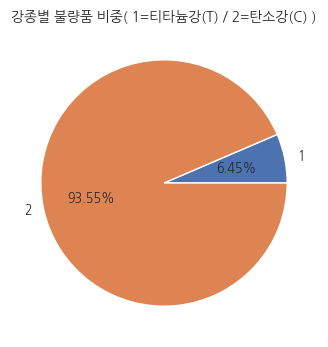

In [ ]:
fig,ax=plt.subplots(figsize=(4,4))
plt.pie(
    df_g['scale_sum'],
    labels=df_g['steel_kind'],
    autopct='%.2f%%',
    textprops={'size':9}
)
plt.title(f"강종별 불량품 비중( 1=티타늄강(T) / 2=탄소강(C) )", fontsize=10)
plt.show()



```
강종별 불량품 비중을 비교하면, C(탄소강)에서 불량품이 더 많이 발생한다.
```



#####2.4.2. HSB( 열간 스케일 파쇄기 )

In [ ]:
# hsb: 적용=1, 미적용=2
df_g=df_raw.groupby('hsb').agg(
    scale_cnt=('scale','count'), # 양품+불량품 개수
    scale_sum=('scale','sum') # 불량품 개수
).reset_index()
df_g['defect_rate']=df_g['scale_sum']/df_g['scale_cnt']*100
df_g

,hsb,scale_cnt,scale_sum,defect_rate
0,1,953,263,27.5971
1,2,47,47,100.0000




```
hsb를 미적용하면 scale은 100% 발생한다.
따라서 scale을 줄이기 위해 hsb는 최우선적으로 적용되어야 한다.
```



#####2.1.4. 압연 방법( rolling_method )

In [ ]:
# rolling_method: TMCP(온도제어)=1, CR(제어압연)=2
df_g=df_raw.groupby('rolling_method').agg(
    scale_cnt=('scale','count'), # 양품+불량품 개수
    scale_sum=('scale','sum') # 불량품 개수
).reset_index()
df_g['defect_rate']=df_g['scale_sum']/df_g['scale_cnt']*100
df_g

,rolling_method,scale_cnt,scale_sum,defect_rate
0,1,160,13,8.1250
1,2,840,297,35.3571


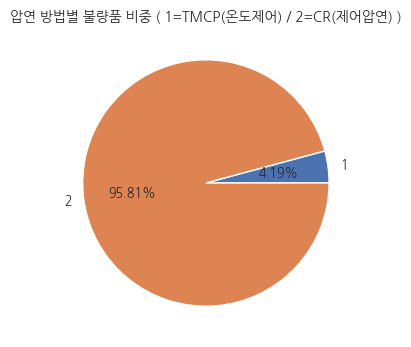

In [ ]:
fig,ax=plt.subplots(figsize=(4,4))
plt.pie(
    df_g['scale_sum'],
    labels=df_g['rolling_method'],
    autopct='%.2f%%',
    textprops={'size':9}
)
plt.title(f"압연 방법별 불량품 비중 ( 1=TMCP(온도제어) / 2=CR(제어압연) )", fontsize=10)
plt.show()



```
CR(제어압연)으로 압연하면 더 많은 불량품이 발생한다.
```



#####2.1.5. 작업조( work_group )별 scale 비교

In [ ]:
df_g=df_raw.groupby('work_group').agg(
    scale_cnt=('scale','count'), # 양품+불량품 개수
    scale_sum=('scale','sum') # 불량품 개수
).reset_index()
df_g['defect_rate']=df_g['scale_sum']/df_g['scale_cnt']*100
df_g

,work_group,scale_cnt,scale_sum,defect_rate
0,1,280,109,38.9286
1,2,292,85,29.1096
2,3,218,66,30.2752
3,4,210,50,23.8095


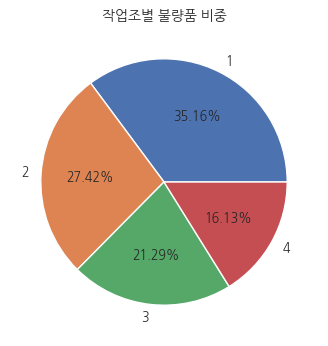

In [ ]:
fig,ax=plt.subplots(figsize=(4,4))
plt.pie(
    df_g['scale_sum'],
    labels=df_g['work_group'],
    autopct='%.2f%%',
    textprops={'size':9}
)
plt.title(f"작업조별 불량품 비중", fontsize=10)
plt.show()



```
pie chart의 결과에서 1조의 작업물 중 불량품 비중이 가장 높았다.
```



###_3. 모델링

In [ ]:
# 최종 df 확인
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   scale            1000 non-null   int64  
 1   steel_kind       1000 non-null   int64  
 2   pt_thick         1000 non-null   int64  
 3   pt_width         1000 non-null   int64  
 4   pt_length        1000 non-null   int64  
 5   hsb              1000 non-null   int64  
 6   fur_heat_temp    1000 non-null   int64  
 7   fur_heat_time    1000 non-null   int64  
 8   fur_soak_temp    1000 non-null   int64  
 9   fur_soak_time    1000 non-null   int64  
 10  fur_total_time   1000 non-null   int64  
 11  rolling_method   1000 non-null   int64  
 12  rolling_temp     1000 non-null   float64
 13  descaling_count  1000 non-null   int64  
 14  work_group       1000 non-null   int64  
dtypes: float64(1), int64(14)
memory usage: 117.3 KB


In [ ]:
%%time
df=df_raw.copy()

CPU times: user 4.38 ms, sys: 2.09 ms, total: 6.46 ms
Wall time: 5.27 ms


In [ ]:
# 표준화
df_num=df[['pt_thick','pt_width','pt_length','fur_heat_temp','fur_heat_time','fur_soak_temp','fur_soak_time','fur_total_time','rolling_temp','descaling_count']]
scaler=StandardScaler()
df_scaled=scaler.fit_transform(df_num)
df_scaled=pd.DataFrame(df_scaled, columns=df_num.columns)

df_scaled=pd.concat([df_scaled, df[['scale','steel_kind','hsb','rolling_method','work_group']]], axis=1)
df_scaled.head(2)

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count,scale,steel_kind,hsb,rolling_method,work_group
0,0.2878,1.7579,-1.5597,-0.6238,1.1403,-1.0342,-0.6177,0.5347,-0.0881,-0.3474,0,1,1,1,1
1,0.2878,1.7579,-1.5597,-0.6238,1.3682,-0.9188,-0.9091,-0.0154,-0.0417,-0.3474,0,1,1,1,1


In [ ]:
# train, test 데이터 7:3 비율로 분할
X_train, X_test, y_train, y_test = train_test_split(
    df_scaled.drop('scale', axis=1),
    df_scaled['scale'],
    test_size=0.3,
    random_state=456
)
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (700, 14), X_test: (300, 14)
y_train: (700,), y_test: (300,)


####3.1. 로지스틱 회귀

In [ ]:
df_scaled.columns

Index(['pt_thick', 'pt_width', 'pt_length', 'fur_heat_temp', 'fur_heat_time',
       'fur_soak_temp', 'fur_soak_time', 'fur_total_time', 'rolling_temp',
       'descaling_count', 'scale', 'steel_kind', 'hsb', 'rolling_method',
       'work_group'],
      dtype='object')

In [ ]:
# 모델 생성
log_model = sm.Logit.from_formula("""scale ~ pt_thick + pt_width + pt_length + fur_heat_temp + fur_heat_time +
                                        fur_soak_temp + fur_soak_time + fur_total_time + rolling_temp +
                                        descaling_count + C(steel_kind) + C(hsb) + C(rolling_method) + C(work_group)"""
                            , data=df_scaled)
log_res = log_model.fit(method='bfgs')
print(log_res.summary())

         Current function value: 0.300917
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      983
Method:                           MLE   Df Model:                           16
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.5139
Time:                        10:36:20   Log-Likelihood:                -300.92
converged:                      False   LL-Null:                       -619.10
Covariance Type:            nonrobust   LLR p-value:                4.372e-125
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1.9140      0.689     -2.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


```
로지스틱 회귀모델의 설명력은 51.39%이다.
```



In [ ]:
# 정확도 예측
train_y_pred = log_res.predict(X_train)
train_y_pred_class = (train_y_pred > 0.5).astype(int)
log_train_acc = metrics.accuracy_score(y_train, train_y_pred_class)

y_pred = log_res.predict(X_test)
y_pred_class = (y_pred > 0.5).astype(int)
y_pred_class.head()
print(f"train accuracy: {log_train_acc:.4f}")

log_f1_score = metrics.f1_score(y_test, y_pred_class)
print(f"f1-score: {log_f1_score:.4f}")

log_test_acc= metrics.accuracy_score(y_test, y_pred_class)
print(f"test accuracy: {log_test_acc:.4f}")

train accuracy: 0.8814
f1-score: 0.7772
test accuracy: 0.8567




```
로지스틱 회귀모델은 85.67%의 정확도를 보였다.
```



####3.2. 의사결정나무

In [ ]:
# 최적의 파라미터 찾기
param_grid=[{'min_samples_leaf': range(5,50,10),
             'max_depth':range(3,12,3),
             'min_samples_split': range(5,50,10)}]

tree=GridSearchCV(DecisionTreeClassifier(random_state=456), param_grid)
tree.fit(X_train, y_train)

print(f"best prameter: {tree.best_params_}")

best prameter: {'max_depth': 9, 'min_samples_leaf': 5, 'min_samples_split': 5}


In [ ]:
# 모델 생성
tree=DecisionTreeClassifier(max_depth=9,
                            min_samples_leaf=5,
                            min_samples_split=5,
                            random_state=456)
tree.fit(X_train, y_train)

# 정확도
tree_train_acc=tree.score(X_train, y_train)
tree_f1_score=metrics.f1_score(y_test, tree.predict(X_test))
tree_test_acc=tree.score(X_test, y_test)
print(f"train accuracy: {tree_train_acc:.4f}")
print(f"f1-score: {tree_f1_score:.4f}")
print(f"test accuracy: {tree_test_acc:.4f}")

train accuracy: 0.9914
f1-score: 0.9846
test accuracy: 0.9900




```
의사결정나무의 정확도는 99%이다.
```



####3.3. 랜덤포레스트

In [ ]:
# 최적의 파라미터 찾기
param_grid=[{'min_samples_leaf': range(5,50,10),
             'max_depth':range(3,12,3),
             'min_samples_split': range(5,50,10)}]

rf_temp=GridSearchCV(RandomForestClassifier(random_state=456), param_grid)
rf_temp.fit(X_train, y_train)

print(f"best prameter: {rf_temp.best_params_}")

best prameter: {'max_depth': 9, 'min_samples_leaf': 5, 'min_samples_split': 15}


In [ ]:
# 모델 생성
rf=RandomForestClassifier(max_depth=9,
                          min_samples_leaf=5,
                          min_samples_split=15,
                          random_state=456)
rf.fit(X_train, y_train)

# 정확도
rf_train_acc=rf.score(X_train, y_train)
rf_f1_score=metrics.f1_score(y_test, rf.predict(X_test))
rf_test_acc=rf.score(X_test, y_test)
print(f"train accuracy: {rf_train_acc:.4f}")
print(f"f1-score: {rf_f1_score:.4f}")
print(f"test accuracy: {rf_test_acc:.4f}")

train accuracy: 0.9643
f1-score: 0.9355
test accuracy: 0.9600




```
랜덤포레스트 모델의 정확도는 96%이다.
```



####3.4. 그래디언트 부스팅

In [ ]:
# 최적의 파라미터 찾기
param_grid=[{'min_samples_leaf': range(5,50,10),
             'max_depth':range(3,12,3),
             'min_samples_split': range(5,50,10)}]

gb_temp=GridSearchCV(GradientBoostingClassifier(random_state=456), param_grid)
gb_temp.fit(X_train, y_train)

print(f"best prameter: {gb_temp.best_params_}")

best prameter: {'max_depth': 3, 'min_samples_leaf': 15, 'min_samples_split': 5}


In [ ]:
# 모델 생성
gb=GradientBoostingClassifier(max_depth=3,
                              min_samples_leaf=15,
                              min_samples_split=5,
                              random_state=456)
gb.fit(X_train, y_train)

# 정확도
gb_train_acc=gb.score(X_train, y_train)
gb_f1_score=metrics.f1_score(y_test, gb.predict(X_test))
gb_test_acc=gb.score(X_test, y_test)
print(f"train accuracy: {gb_train_acc:.4f}")
print(f"f1-score: {gb_f1_score:.4f}")
print(f"test accuracy: {gb_test_acc:.4f}")

train accuracy: 0.9943
f1-score: 0.9898
test accuracy: 0.9933




```
그래디언트 부스팅 모델의 정확도는 99.33%이다.
```



####3.5. XGBoost

In [ ]:
# 최적의 파라미터 찾기
param_grid=[{'min_samples_leaf': range(5,50,10),
             'max_depth':range(3,12,3),
             'min_samples_split': range(5,50,10)}]

xgb_temp=GridSearchCV(XGBClassifier(random_state=456), param_grid)
xgb_temp.fit(X_train, y_train)

print(f"best prameter: {xgb_temp.best_params_}")

best prameter: {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 5}


In [ ]:
# 모델 생성
xgb=XGBClassifier(max_depth=3,
                  min_samples_leaf=5,
                  min_samples_split=5,
                  random_state=456)
xgb.fit(X_train, y_train)

# 정확도
xgb_train_acc=xgb.score(X_train, y_train)
xgb_f1_score=metrics.f1_score(y_test, xgb.predict(X_test))
xgb_test_acc=xgb.score(X_test, y_test)
print(f"train accuracy: {xgb_train_acc:.4f}")
print(f"f1-score: {xgb_f1_score:.4f}")
print(f"test accuracy: {xgb_test_acc:.4f}")

train accuracy: 1.0000
f1-score: 0.9846
test accuracy: 0.9900




```
XGBoost 모델의 정확도는 99%이지만 과적합되어 있다.
```



####3.6. SVM

In [ ]:
# 최적의 파라미터 찾기
param_grid=[{'C': [0.1, 1, 10],
             'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
             'gamma': ['scale','auto',0.1, 1]}]

svm_temp=GridSearchCV(SVC(random_state=456), param_grid)
svm_temp.fit(X_train, y_train)

print(f"best prameter: {svm_temp.best_params_}")

best prameter: {'C': 1, 'gamma': 0.1, 'kernel': 'poly'}


In [ ]:
# 모델 생성
svm=SVC(C=1,
        gamma=0.1,
        kernel='poly',
        random_state=456)
svm.fit(X_train, y_train)

# 정확도
svm_train_acc=svm.score(X_train, y_train)
svm_f1_score=metrics.f1_score(y_test, svm.predict(X_test))
svm_test_acc=svm.score(X_test, y_test)
print(f"train accuracy: {svm_train_acc:.4f}")
print(f"f1-score: {svm_f1_score:.4f}")
print(f"test accuracy: {svm_test_acc:.4f}")

train accuracy: 0.9371
f1-score: 0.8191
test accuracy: 0.8867




```
SVM( Support Vector Machine ) 모델의 정확도는 88.67%이다.
```



###_4. 모델 평가


![image.png](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FKOF1X%2FbtrWPtlh2UR%2FlaICuoSjVjjzJgSaFH026K%2Fimg.png)
```
분류 모델의 평가 지표 중 Accuracy F1-score를 비교하여 모델을 선정할 것이다.

Accuracy(정확도) = (TP+TN)/(전체 샘플)
Precision(정밀도) = TP/(TP+FP)
Recall(재현율) = TP/(TP+FN)

F1-score = Precision과 Recall의 조화평균
Precision Recall 모두 예측과 실제가 모두 positive한 데이터에 관심을 갖는 지표이다.
Precision Recall 성능을 동시에 고려하기 위해 F1-score를 사용하기로 결정했다.
```



In [ ]:
%%time
model=['Logistic','Decision Tree','Random Forest','Gradient Boosting','XGBoost','SVM']
train_acc=[]
test_acc=[]
f1_score=[]

# 로지스틱회귀
train_acc.append(log_train_acc)
test_acc.append(log_test_acc)
f1_score.append(log_f1_score)

# 의사결정나무
train_acc.append(tree_train_acc)
test_acc.append(tree_test_acc)
f1_score.append(tree_f1_score)

# 랜덤포레스트
train_acc.append(rf_train_acc)
test_acc.append(rf_test_acc)
f1_score.append(rf_f1_score)

# 그래디언트부스팅
train_acc.append(gb_train_acc)
test_acc.append(gb_test_acc)
f1_score.append(gb_f1_score)

# XGBoost
train_acc.append(xgb_train_acc)
test_acc.append(xgb_test_acc)
f1_score.append(xgb_f1_score)

# SVM
train_acc.append(svm_train_acc)
test_acc.append(svm_test_acc)
f1_score.append(svm_f1_score)


CPU times: user 46 µs, sys: 0 ns, total: 46 µs
Wall time: 52.2 µs


In [ ]:
df_res=pd.DataFrame({'model':model,
                     'train accuracy':train_acc,
                     'test accuracy':test_acc,
                     'f1-score':f1_score}).set_index('model')
df_res.round(4)

,train accuracy,test accuracy,f1-score
model,,,
Logistic,0.8814,0.8567,0.7772
Decision Tree,0.9914,0.9900,0.9846
Random Forest,0.9643,0.9600,0.9355
Gradient Boosting,0.9943,0.9933,0.9898
XGBoost,1.0000,0.9900,0.9846
SVM,0.9371,0.8867,0.8191




```
Accuracy와 F1-score가 모두 가장 높은 모델은 Gradient Boosting이다.

```



In [ ]:
# 최적 파라미터로 최종 모델 생성
fin_model=GradientBoostingClassifier(max_depth=3,
                                     min_samples_leaf=15,
                                     min_samples_split=5,
                                     random_state=456)
fin_model.fit(X_train, y_train)

y_pred=fin_model.predict(X_test)

# confusion matrix 출력
print(f"Confusion Matrix:\n{metrics.confusion_matrix(y_test, y_pred)}")
print()

# 정확도 출력
acc=metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")
print()

# classification report 출력
print(f"Classification Report:\n{metrics.classification_report(y_test, y_pred)}")

Confusion Matrix:
[[201   0]
 [  2  97]]

Accuracy: 0.9933

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       201
           1       1.00      0.98      0.99        99

    accuracy                           0.99       300
   macro avg       1.00      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



```
양품에 속하는 201개의 샘플이 정확하게 예측되었다.
불량품에 속하는 2개의 샘플이 오분류되었고 97개가 정확하게 예측되었다.

정확도는 99.33%로 높은 확률로 올바르게 분류되었다고 판단했다.
precision, recall, f1-score 모두 1 혹은 1에 가까운 값을 보이므로 데이터셋에 대한 일반화 성능이 좋다고 평가된다.
```



###_5. 결론


```
Gradient Boosting 모델을 사용했을 때의 설명변수의 중요도는 다음과 같다.
```



In [ ]:
df_importance=pd.DataFrame()
df_importance['feature']=X_train.columns
df_importance['importance']=fin_model.feature_importances_
df_importance.sort_values('importance', ascending=False, inplace=True)
df_importance.round(3)

,feature,importance
8,rolling_temp,0.5500
11,hsb,0.1740
5,fur_soak_temp,0.1580
9,descaling_count,0.0790
0,pt_thick,0.0340
7,fur_total_time,0.0020
1,pt_width,0.0010
6,fur_soak_time,0.0010
2,pt_length,0.0010
3,fur_heat_temp,0.0010




```
Gradient Boosting 모델의 결과로 나온 주요 인자는 다음과 같다.

    rolling_temp, hsb, fur_soak_temp, descaling_count, pt_thick

압연온도, HSB 적용 여부, 가열로 균열대 소재온도, 압연 descaling 횟수, plate(후판) 지시두께이다.
앞서 EDA를 통해 가열로 균열대 소재온도와 가열로 추출온도(fur_ex_temp)가 완벽히 정비례해 가열로 추출온도를 제거했다.
따라서 가열로 추출온도 또한 주요 인자라고 판단했다.
```



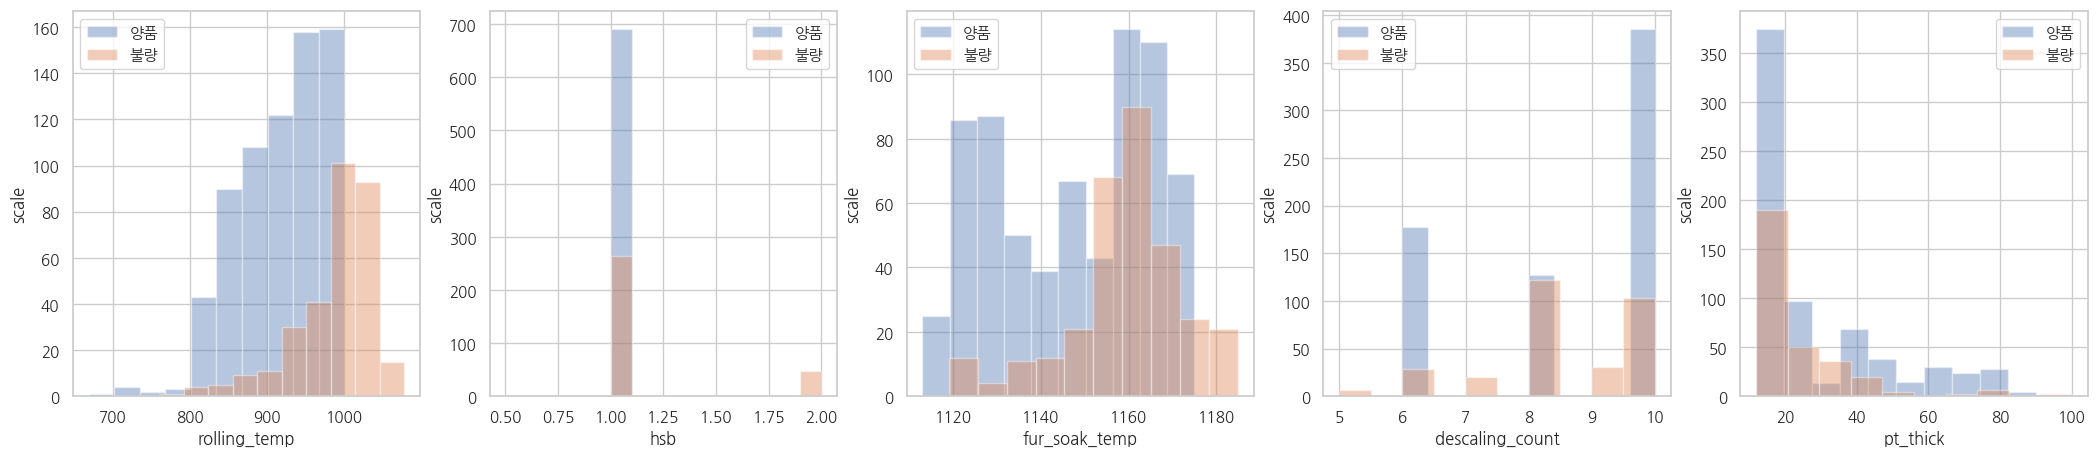

In [ ]:
# histogram으로 분포 확인
fig,axes=plt.subplots(1,5,figsize=(26,5))
i=0
col=['rolling_temp','hsb','fur_soak_temp','descaling_count','pt_thick']
for col in col:
    sns.distplot(
        df[df['scale']==0][col],
        label='양품',
        ax=axes[i],
        bins=10,
        kde=False)
    sns.distplot(
        df[df['scale']==1][col],
        label='불량',
        ax=axes[i],
        bins=10,
        kde=False)
    axes[i].set_ylabel('scale')
    axes[i].legend()
    i+=1
plt.show()


```
히스토그램을 통해 주요 인자를 어떻게 조절해야 할지 판단할 수 있다.
```



> 압연 공정에서 Scale 발생을 줄이기 위한 방법은 다음과 같다.  
> 1. 압연 온도(rolling_temp)를 낮춘다.
> 2. HSB(hsb)를 적용한다.
> 3. 가열로 균열대 온도(fur_soak_temp)를 낮춘다.
> 4. 압연 중 디스케일링 횟수(descaling_count)를 늘린다.
> 5. 후판 두께(pt_thick)를 얇게 한다.